## Vehicle Detection
---
### Goals & Objectives

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.
---

In [1]:
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
from utils.utils import ImgFeatExtract
# autoreload plugin
# this will automatically update the imported modules with the changes made on the fly in the functions.py script
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Feature Extraction - Histogram of Oriented Gradients (HOG)
Please refer to the utils/utils.py file that contains `ImgFeatExtract` class and the functions that perform the feature extraction. 

This is the final configuration chosen to instantiate `ImgFeatExtract` class after performing a parameter fine-tuning. 

In [3]:
feature_config = {
    'color_space' : 'YCrCb',  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient' : 12,
    'pix_per_cell' : 8,
    'cell_per_block' : 2,
    'hog_channel' : 'ALL',
    'spatial_size' : (32, 32), # Spatial binning dimensions
    'hist_bins' : 32,
    'spatial_feat' : True,
    'hist_feat' : True,
    'hog_feat' : True
}

Test the `ImgFeaExtractor` in a random image from my vehicles dataset. 

([], <a list of 0 Text yticklabel objects>)

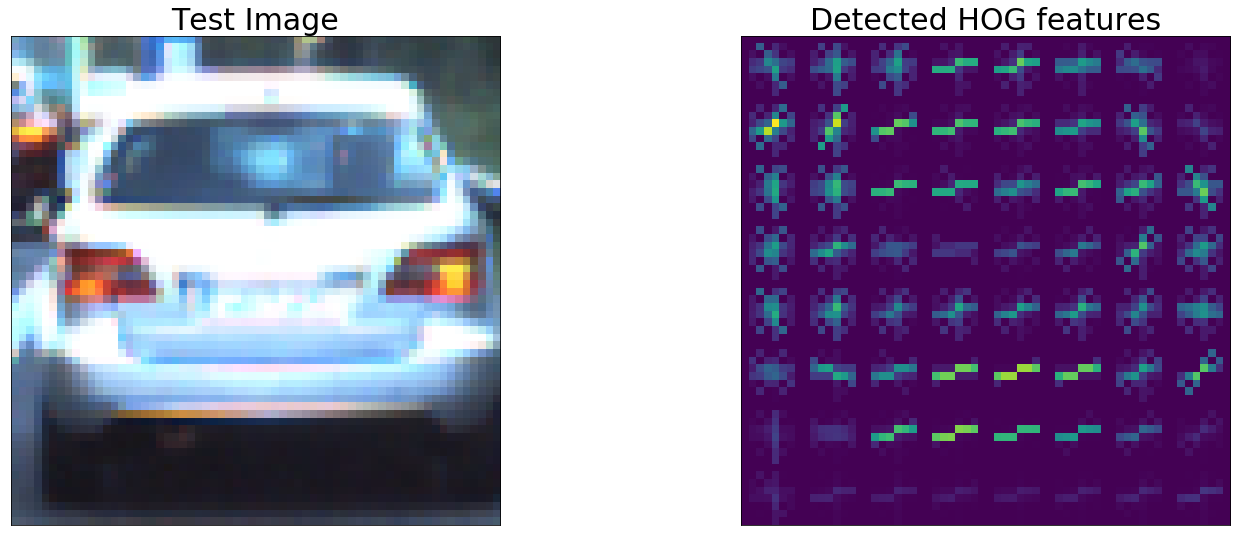

In [4]:
test_image = mpimg.imread('../vehicles/KITTI_extracted/31.png')
ife = ImgFeatExtract(feature_config)
hog_img = ife.get_hog_feat_img(test_image, 0)
del ife

plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Test Image',fontsize=30)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(hog_img)
plt.title('Detected HOG features',fontsize=30)
plt.xticks([])
plt.yticks([])

## 2. Training the classifier

A Linear SVM was chosen as my classifier. SVC provides relatively high accuracy and fast computation, which makes it a good fit for this type of job. 
Here are the steps followed to train the classifier:
1. Read all the positive images (with cars)
2. Read all the negative images (without cars)
3. Instantiate my feature extractor `ImageFeatureExtractor` with the chosen configuration.
4. Stack the feature vectors (HOG, Spatial, Color Histogram) together and create the labels. 
5. Split data into train and test, 70-30. 
6. Instantiate a `LinearSVC` , fit it to the features and test its accuracy. 

Please refer to the utils/utils.py file that contains `train()` function that performs the steps mentioned above using the feature configuration preselected. 

In [19]:
svc, X_scaler = train(feature_config)

Extracting features...
113.65 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460

Training classifier...
19.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9936


Without tuning the hyperparameters of the LinearSVM and simply using the ones that come by default, we achieve an accuracy of 99.36%, which is pretty good for the model. 

## 3. Sliding Window Search
This is the combination of parameters chosen for my sliding window configuration. This combination was chosen after performing parameter fine-tuning in a way that minimize the number of False Positive cases.

Please refer to the utils/utils.py file that contains `ObjDetect` class and the function that scans images to detect vehicles. This algorithm is implemented in 2-steps: perform the images processing and object detection. 

The `process_and_display()` function has the following steps:
- Pyramid search or Scale search: We slide the windows across the image at different scales. This is good to detect objects in varying sizes, like cars driving on the road that are at different distances from me. This method is applied using `get_sliding_windows` in  `process_and_display` of class ObjDetect. 
- This method in-turn calls method `get_sliding_windows` passing it a different scale (or image size) on each iteration. `get_sliding_windows` returns an array of window points (rectangles). 

In [62]:
sliding_windows_config = {
    'xy_overlap' : (0.75, 0.8),
    'xy_window' : [64, 64],
    'y_start_stop' : [320, 680],
    'x_start_stop' : [760, 1260],
    'window_sizes' : [60, 100, 150],
    'heat_threshold' : 2
}

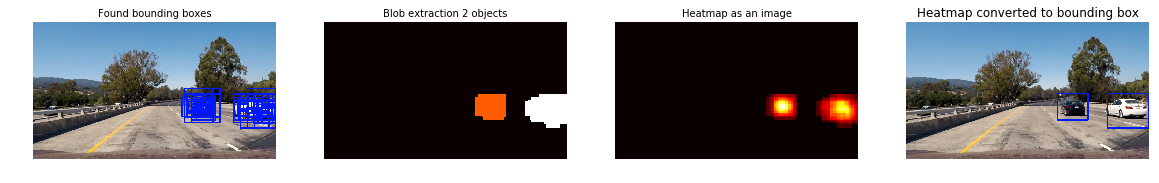

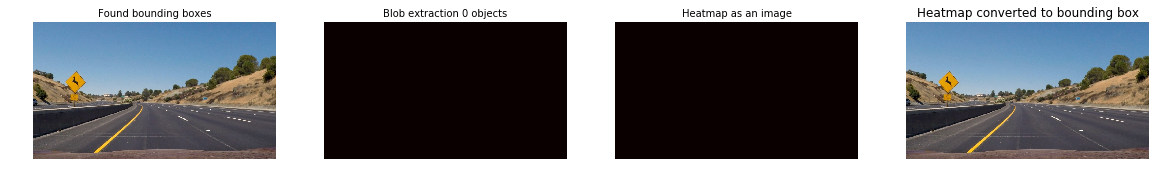

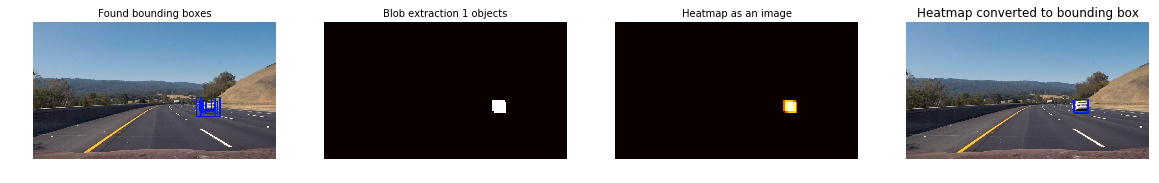

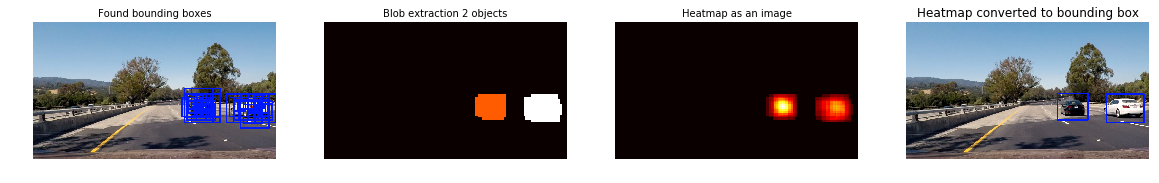

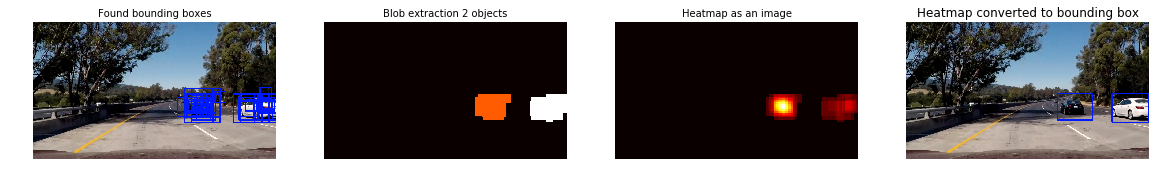

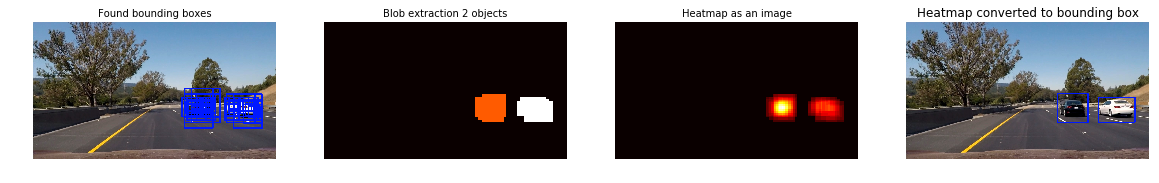

In [59]:
from utils.utils import ObjDetect
glob_test_images = glob.glob('../test_images/*.jpg')
detector = ObjDetect(feature_config, sliding_windows_config, svc, X_scaler)

for file in glob_test_images:
    image = mpimg.imread(file)
    detector.process_and_display(image)

### Test the pipeline on the test images
Here we test the pipeline calling `process()` function of class `ObjDetect` on the test images. As we can see, the detector does a good job identifying and framing the vehicles on the road. 

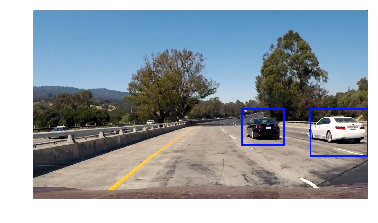

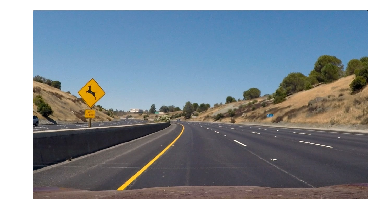

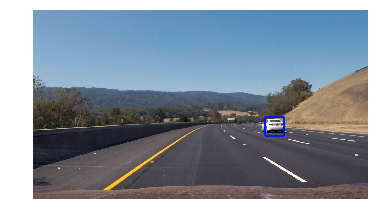

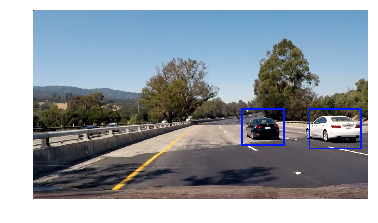

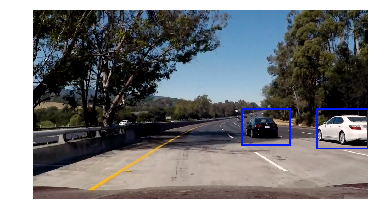

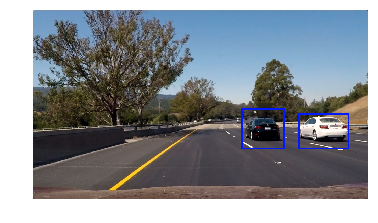

In [60]:
glob_test_images = glob.glob('../test_images/*.jpg')
del detector
detector = ObjDetect(feature_config, sliding_windows_config, svc, X_scaler)

for file in glob_test_images:
    image = mpimg.imread(file)
    plt.imshow(detector.process(image))
    plt.axis('off')
    plt.show()

## 4. Video Implementation

### Test video

In [61]:
video_output = '../output_images/test_video_output.mp4'
#clip1 = VideoFileClip('project_video.mp4')
clip1 = VideoFileClip('../test_video.mp4')
clip1_output = clip1.fl_image(detector.process) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/test_video_output2.mp4
[MoviePy] Writing video ../output_images/test_video_output2.mp4


 97%|█████████▋| 38/39 [05:52<00:09,  9.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/test_video_output2.mp4 

CPU times: user 5min 35s, sys: 2.64 s, total: 5min 38s
Wall time: 5min 54s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Project Video

In [61]:
video_output = '../output_images/project_video_output.mp4'
#clip1 = VideoFileClip('project_video.mp4')
clip1 = VideoFileClip('../project_video.mp4')
clip1_output = clip1.fl_image(detector.process) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/test_video_output2.mp4
[MoviePy] Writing video ../output_images/test_video_output2.mp4


 97%|█████████▋| 38/39 [05:52<00:09,  9.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/test_video_output2.mp4 

CPU times: user 5min 35s, sys: 2.64 s, total: 5min 38s
Wall time: 5min 54s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))